In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import wntr
import scipy as sc
import networkx as nx
import networkx.drawing.nx_pylab as nxp
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample
import random
import time
import pickle
import pipedream_utility as pdu
from pipedream_utility import *
import pipedream_simulation as pd_sim
from pipedream_simulation import *
import pipedream_simulation_sensor_results as pd_sim_sensor
from pipedream_simulation_sensor_results import *
from pipedream_kalman_filter import apply_EKF
import viswaternet as vis

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
images_dir = 'img/'
 
# INPUTS ######################################################################
sensors_list = []  
max_sensors = 2
percentile = 90
cutoff_timestep = 5
metric = 'mean'
percent = True
Rcov_case = 1
banded = False
source_node = True

t_run = 24
Rcov_case=1

In [2]:
%matplotlib inline

In [3]:
config = {
    'Net2' : {
        'sensor_list' : ['3', '22', '7', '36', '1'],
        'tanks_list' : ['26'],
        'sources_list' : [],
        'dt' : 900,
        'axnum' : 0,
        'node_size' : 400,
        'buffer_distance' : 2
    },
    'CA1' : {
        'sensor_list' : ['1411', '179', '115', '213', '1821'],
        'tanks_list' : ['185'],
        'sources_list' : [],
        'dt' : 900,
        'axnum' : 1,
        'node_size' : 400,
        'buffer_distance' : 200
    },
    'PA1' : {
        'sensor_list' : ['433', '221', '190', '163', '293'],
        'tanks_list' : ['338', '186'],
        'sources_list' : [],
        'dt' : 1800,
        'axnum' : 2,
        'node_size' : 400,
        'buffer_distance' : 1500
    }
}

In [4]:
kf = {}

for inp in config:
    kf[inp] = {}
    inp_path = f'./networks/{inp}.inp'
    wn = wntr.network.WaterNetworkModel(inp_path)
    sensor_list = config[inp]['sensor_list']
    known_measurements_list = config[inp]['tanks_list'] + config[inp]['sources_list']
    dt = config[inp]['dt']
    msmts = known_measurements_list + sensor_list
    m = len(msmts)
    n = wn.num_nodes + wn.num_tanks # we are adding the "fake" nodes connected to tank orifices
    sensor_std_dev = 0.1
    Qcov = (10) * np.eye(n)

    for i in range(len(msmts)):
        print(f'Model: {inp}, Sensors: {i}')
        subset = msmts[:i+1]
        Rcov = (0.5**2) * np.eye(i + 1)
        H_df_kf, H_df_real, H_df_model, H_df_sensor, model = apply_EKF(inp_path, subset, t_run=t_run, dt=dt,
                                                                       banded=banded, Rcov=Rcov, Qcov=Qcov, sensor_std_dev=sensor_std_dev, 
                                                                       num_iter=40)
        kf[inp][i+1] = H_df_kf
    kf[inp][0] = H_df_model
    kf[inp][-1] = H_df_real

Model: Net2, Sensors: 0
Model: Net2, Sensors: 1
Model: Net2, Sensors: 2
Model: Net2, Sensors: 3
Model: Net2, Sensors: 4
Model: Net2, Sensors: 5
Model: CA1, Sensors: 0


/Users/mdbartos/miniconda3/lib/python3.8/site-packages/pipedream_solver/nsuperlink.py:1211: LinAlgWarning: Ill-conditioned matrix (rcond=3.0574e-18): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)
/Users/mdbartos/miniconda3/lib/python3.8/site-packages/pipedream_solver/nsuperlink.py:1211: LinAlgWarning: Ill-conditioned matrix (rcond=2.71626e-18): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)
/Users/mdbartos/miniconda3/lib/python3.8/site-packages/pipedream_solver/nsuperlink.py:1211: LinAlgWarning: Ill-conditioned matrix (rcond=1.08432e-17): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)


Model: CA1, Sensors: 1
Model: CA1, Sensors: 2
Model: CA1, Sensors: 3
Model: CA1, Sensors: 4
Model: CA1, Sensors: 5
Model: PA1, Sensors: 0
Model: PA1, Sensors: 1
Model: PA1, Sensors: 2
Model: PA1, Sensors: 3
Model: PA1, Sensors: 4
Model: PA1, Sensors: 5
Model: PA1, Sensors: 6


In [5]:
mads = {}

for inp in config:
    mads[inp] = {}
    sensor_list = config[inp]['sensor_list']
    known_measurements_list = config[inp]['tanks_list'] + config[inp]['sources_list']
    msmts = known_measurements_list + sensor_list
    for i in range(len(msmts) + 1):
        mads[inp][i] = (kf[inp][i] - kf[inp][-1]).abs()

In [6]:
all_node_mean_heads = pd.concat([(mads[inp][len(config[inp]['sensor_list']) 
                                            + len(config[inp]['tanks_list']) 
                                            + len(config[inp]['sources_list'])]).mean(axis=0) for inp in config]).reset_index(drop=True)

## Figure 3. EKF results: (left) sensor locations and MAD of nodal heads where numbers indicate the order in which sensors are added, and (right) mean MAD across all nodes in the networks with each added sensor. The red labels indicate the order in which sensors are placed in the networks.

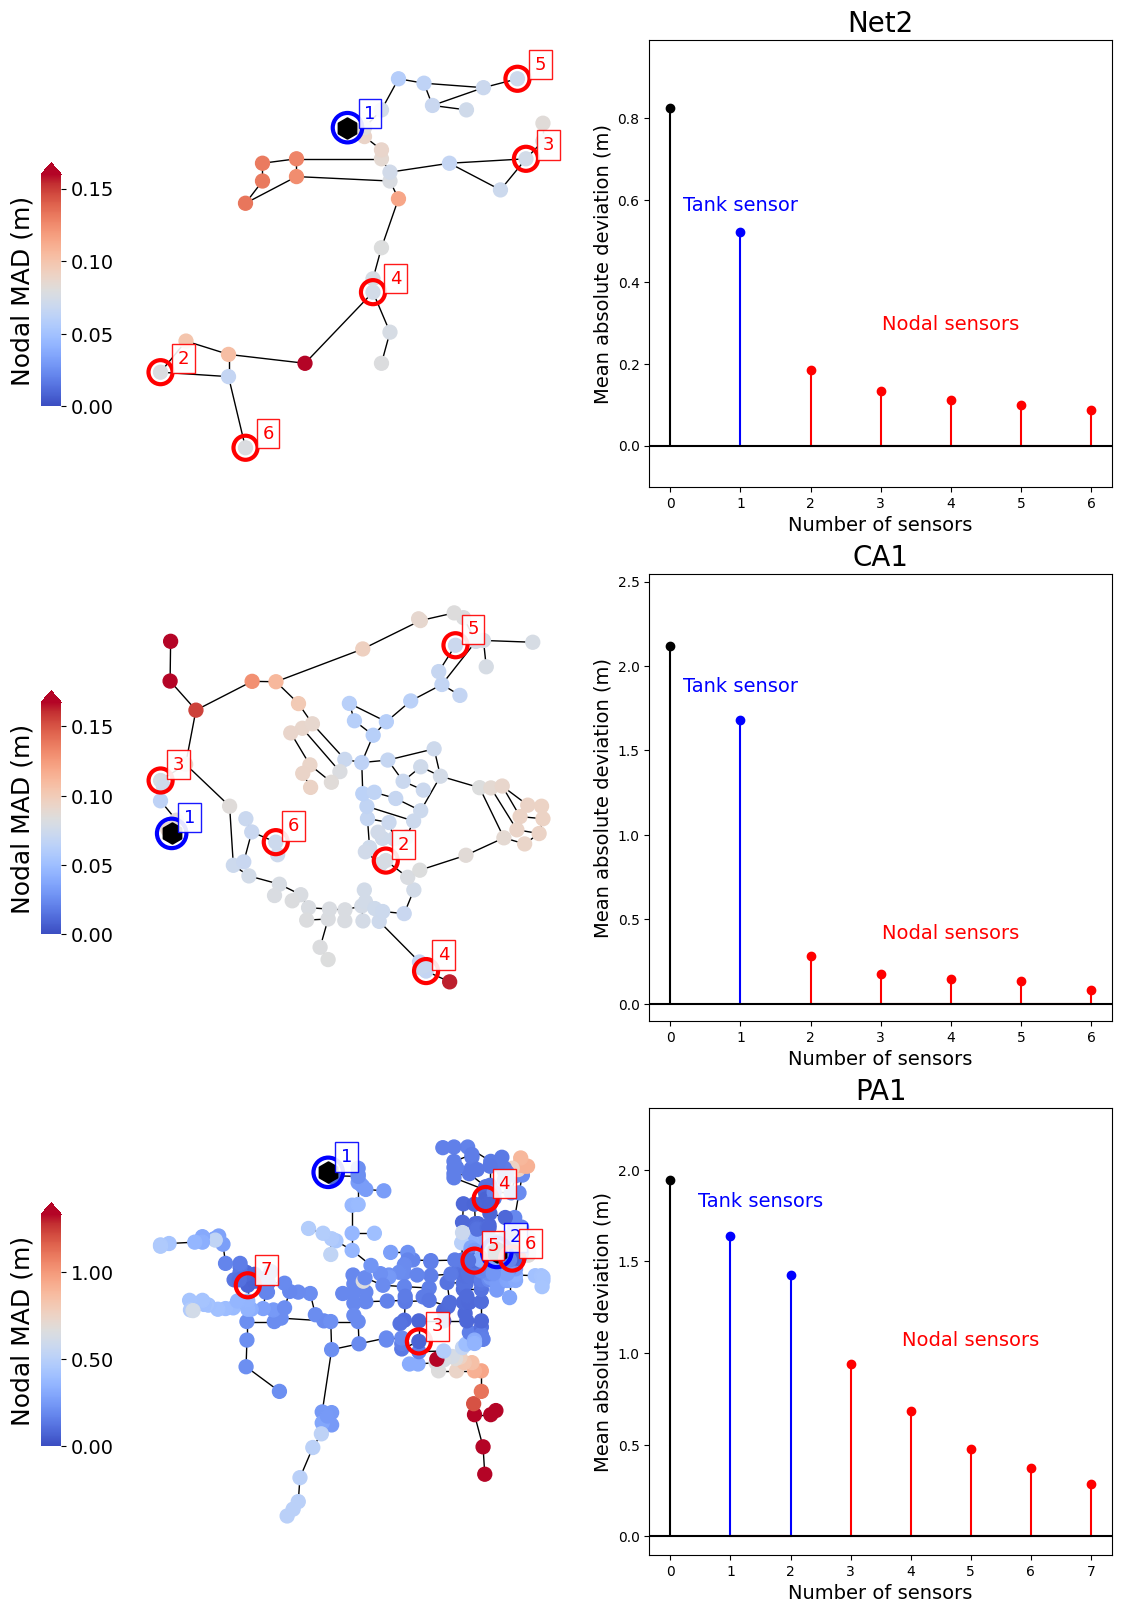

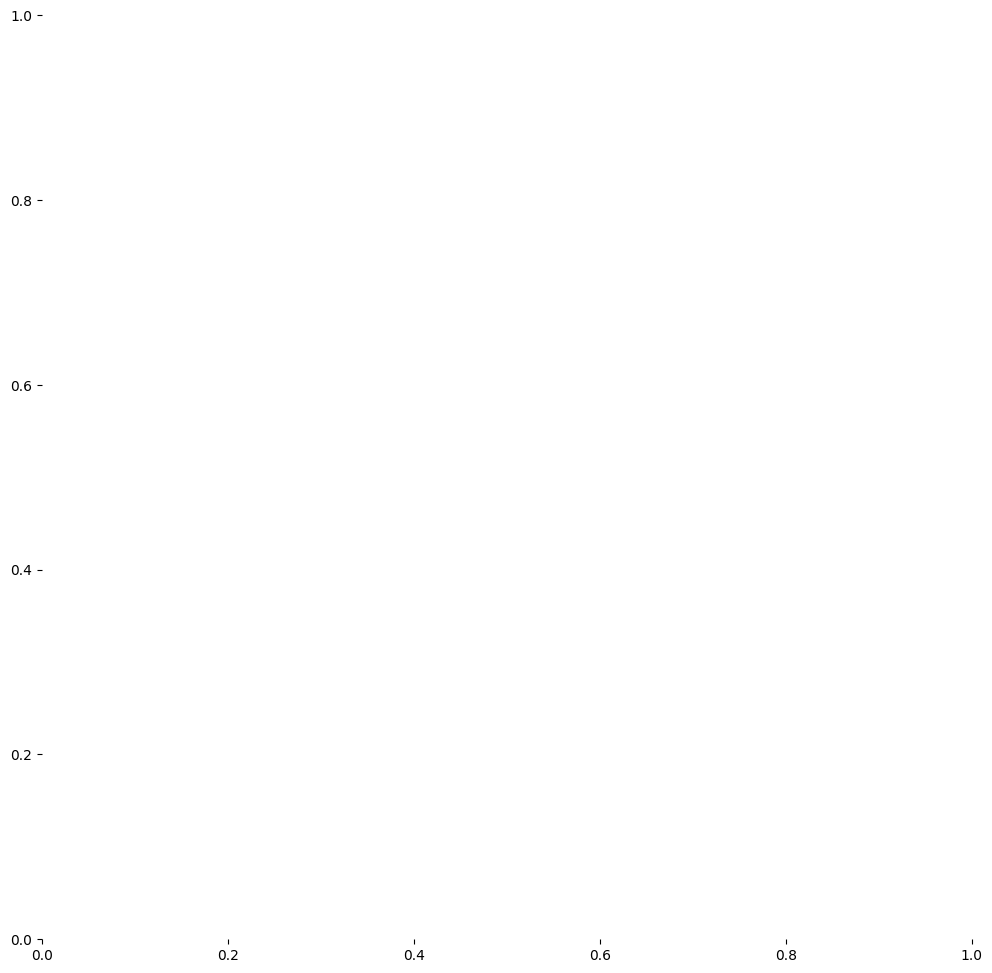

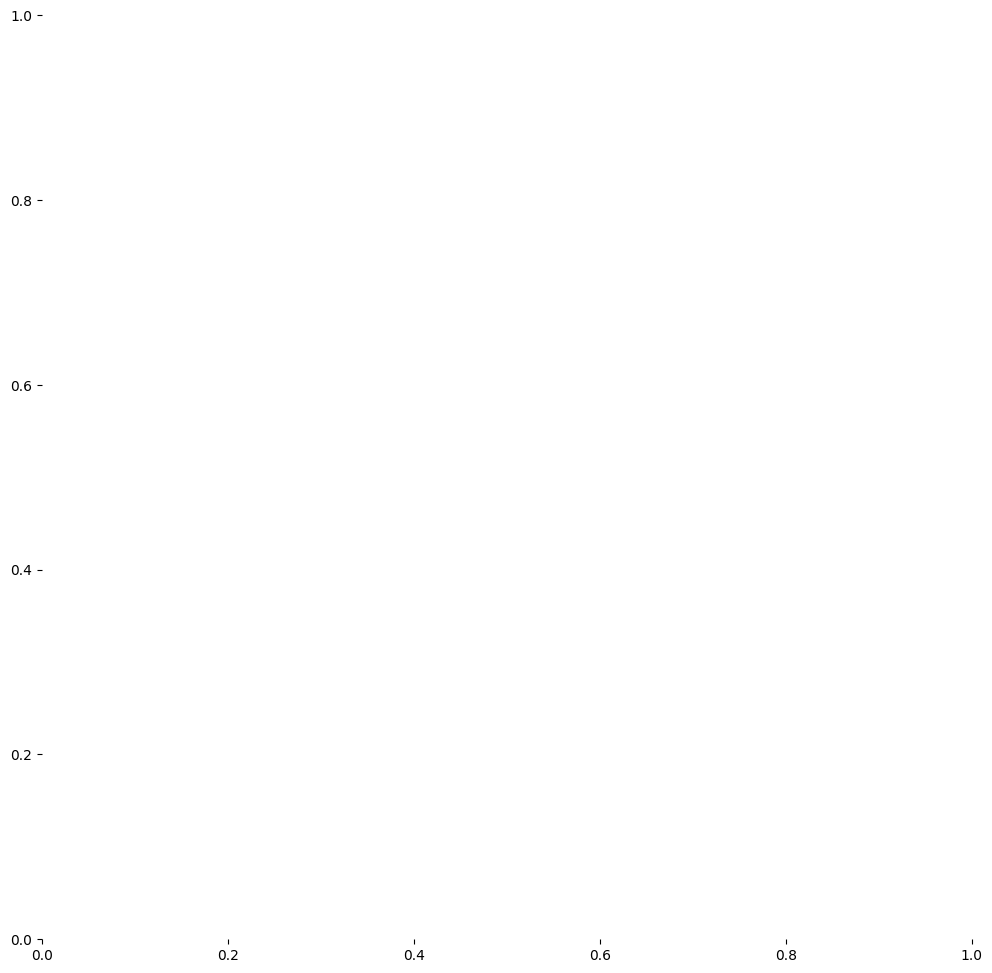

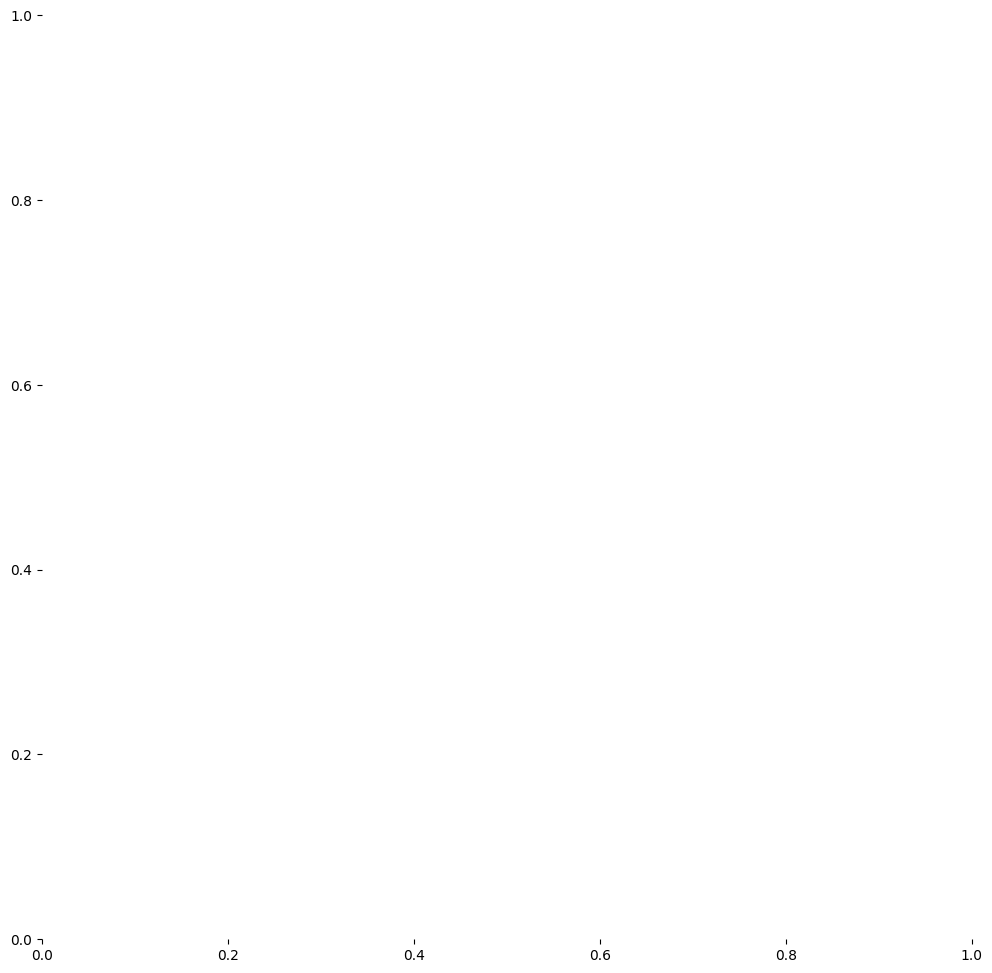

In [7]:
import matplotlib.ticker as tkr

fig, ax = plt.subplots(3, 2, gridspec_kw={'height_ratios': [1,1,1]}, figsize = (10,16), layout='constrained')
cmap = 'coolwarm'

fs = 18

max_limit = all_node_mean_heads.quantile(0.95)

for inp in config:
    inp_path = f'./networks/{inp}.inp'
    axnum = config[inp]['axnum']
    node_size = config[inp]['node_size']
    tanks_list = config[inp]['tanks_list']
    sources_list = config[inp]['sources_list']
    rem_sensor_list = config[inp]['sensor_list']
    sensors_list = tanks_list + sources_list + rem_sensor_list
    buffer_distance = config[inp]['buffer_distance']
    num_tanks = len(config[inp]['tanks_list'])
    num_sources = len(config[inp]['sources_list'])
    plural = 's' if num_tanks > 1 else ''
    wn = wntr.network.WaterNetworkModel(inp_path)
    vis_model = vis.VisWNModel(inp_path)
    
    junction_names = mads[inp][1].columns
    junction_names = list(junction_names)
    for name in wn.tank_name_list:
        junction_names.remove('i'+name)
        junction_names.remove(name)
        
    ax[axnum][1].set_title(inp, fontsize = fs+2)
    ax[axnum][0].set_frame_on(False) 
    errors = (mads[inp][len(config[inp]['sensor_list']) 
                         + len(config[inp]['tanks_list']) 
                         + len(config[inp]['sources_list']) ])[junction_names].mean(axis=0)
    max_limit = errors.quantile(0.99)
    vis_model.plot_unique_data(ax=ax[axnum][0], parameter = "custom_data", parameter_type = 'node', 
                                       custom_data_values = [junction_names, errors], data_type = 'continuous', 
                                       cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = False,  
                                       node_size = node_size, legend=False, tank_color='k')
    vis_model.draw_nodes(ax=ax[axnum][0], node_list = tanks_list, node_color = "none", node_size = 1800, edge_colors = 'b', line_widths = 3)
    #vis_model.draw_nodes(ax=ax[1][axnum], node_list = sources_list, node_color = "none", node_size = 1200, edge_colors = 'g', line_widths = 3)    
    vis_model.draw_nodes(ax=ax[axnum][0], node_list = rem_sensor_list, node_color = "none", node_size = 1200, edge_colors = 'r', line_widths = 3)
    for j in range(len(sensors_list)):
        sensor = sensors_list[j]
        if sensor in config[inp]['tanks_list']:
            c = 'b'
        #elif sensor in config[inp]['sources_list']:
        #    c = 'g'
        else:
            c = 'r'
        ax[axnum][0].text(wn.get_node(sensors_list[j]).coordinates[0]+buffer_distance, wn.get_node(sensors_list[j]).coordinates[1]+buffer_distance, '{}'.format(j+1), color=c , fontsize = 13, 
                   bbox=dict(facecolor='white', alpha = 0.9, edgecolor=c))
        
    ax[axnum][1].stem([0], [mads[inp][0].mean().mean()], linefmt='k', markerfmt='ko')
    ax[axnum][1].stem(np.arange(1, 1 + num_tanks), [mads[inp][i].mean().mean() for i in range(1, 1 + num_tanks)], linefmt='b',
                     markerfmt='bo')
    #ax[0][axnum].stem(np.arange(1 + num_tanks, 1 + num_tanks + num_sources),
    #                  [mads[inp][i].mean().mean() for i in range(1 + num_tanks, 1 + num_tanks + num_sources)], linefmt='g')
    ax[axnum][1].stem(np.arange(1 + num_tanks + num_sources, 1 + len(sensors_list)),
                     [mads[inp][i].mean().mean() for i in range(1 + num_tanks + num_sources, 1 + len(sensors_list))], linefmt='r',
                     markerfmt='ro')
    ax[axnum][1].axhline(0, c='k')
    ax[axnum][1].text((1 + num_tanks) / 2 ,
                      1.1 * max([mads[inp][i].mean().mean() for i in range(1, 1 + num_tanks)]),
                      f'Tank sensor{plural}', c='b', ha='center', fontsize=14)
    #ax[0][axnum].text((1 + num_tanks + num_tanks + num_sources) / 2,
    #                  1.2 * max([mads[inp][i].mean().mean() for i in range(1 + num_tanks, 1 + num_tanks + num_sources)]),
    #                  'Source sensor', c='g', ha='center')
    ax[axnum][1].text((1 + num_tanks + num_sources + len(sensors_list)) / 2,
                      0.1 + max([mads[inp][i].mean().mean() for i in range(1 + num_tanks + num_sources, 1 + len(sensors_list))]),
                      'Nodal sensors', c='r', ha='center', fontsize=14)
    ax[axnum][1].set_xlabel('Number of sensors', size=14)
    ax[axnum][1].set_ylabel('Mean absolute deviation (m)', size=14)
    #ax[1][axnum].set_title('Net2: Mean absolute deviation in nodal heads (m)', size=14)
    ax[axnum][1].set_ylim(-0.1, 1.2 * mads[inp][0].mean().mean())

    norm = mpl.colors.Normalize(vmin=0,vmax=max_limit)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    dims = [ax[axnum][0].get_position().x0-0.2, 
            ax[axnum][0].get_position().y0+0.05,
            0.02,
            ax[axnum][0].get_position().x1 - ax[axnum][0].get_position().x0-0.2]
    if axnum == 0:
        bottom = 0.75
    if axnum == 1:
        bottom = 0.42
    if axnum == 2:
        bottom = 0.1    
    dims2 = ([ax[axnum][0].get_position().x0-0.2, 
              bottom, 
              0.02,
              ax[axnum][0].get_position().x1 - ax[axnum][0].get_position().x0-0.2])
    cax = fig.add_axes(dims2)
    cb = fig.colorbar(sm, cax=cax, orientation = 'vertical', extend='max', format = tkr.FormatStrFormatter('%.2f'))
    cb.ax.tick_params(labelsize=14)
    cb.set_label(label='Nodal MAD (m)',fontsize = fs, labelpad=-75)
    cb.outline.set_visible(False)
#fig.tight_layout()
fig.savefig('img/state_estimation_v2.pdf', bbox_inches='tight')
fig.savefig('img/state_estimation_v2.png', dpi=200, bbox_inches='tight')